## Bayesian Linear Regression Using NN

In [1]:
# Importing libraries
from laplace import Laplace
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import torch.distributions as dist
from functools import partial
import jax.tree_util as jtu
import hamiltorch
from numpy import linalg as la

torch.manual_seed(42)

#### Generating a simple linear dataset with a gaussian noise with variance 1

In [2]:
# Generating data
N = 10
X = torch.linspace(0, 2, N).reshape(-1, 1)
y = X + 0.3 * torch.randn(N, 1)

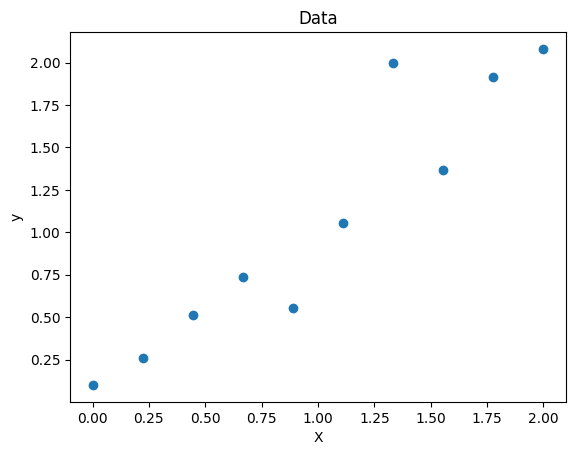

In [3]:
# Plotting the data
plt.scatter(X, y)
plt.xlabel('X')
plt.ylabel('y')
plt.title('Data')
plt.show()

#### Creating a Simple Neural Network for linear regression

In [4]:
# Defining the model
model = torch.nn.Sequential(
    torch.nn.Linear(1, 1)
)

In [5]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.4607]], requires_grad=True),
 Parameter containing:
 tensor([-0.1173], requires_grad=True)]

#### Training our model on the dataset

In [6]:
EPOCHS = 2500
LR = 0.02

In [7]:
# Training the model
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
for i in range(EPOCHS):
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

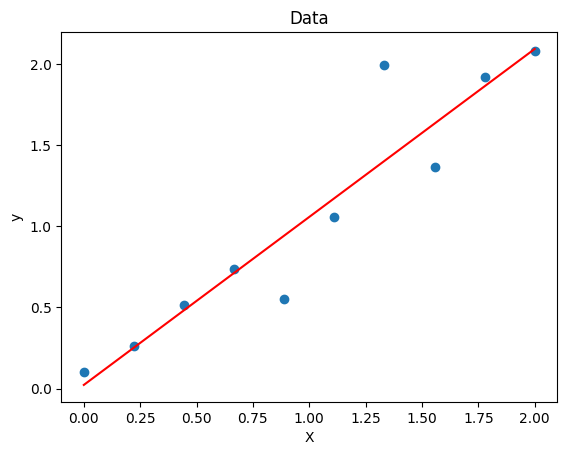

In [8]:
# Plotting the results
plt.scatter(X, y)
plt.plot(X, model(X).detach().numpy(), 'r')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Data')
plt.show()

In [9]:
# Output the mean loss of the model and the MLE parameters
y_pred = model(X)
loss = loss_fn(y_pred, y)
print('Mean loss of the model: ', loss.item())
print('MLE parameters: ', list(model.parameters()))

Mean loss of the model:  0.06010859087109566
MLE parameters:  [Parameter containing:
tensor([[1.0345]], requires_grad=True), Parameter containing:
tensor([0.0231], requires_grad=True)]


#### Using the Laplace Library to fit a posterior and get the predictive posterior

In [10]:
# Creating the dataset to use in the Laplace approximation model
train_dataset = torch.utils.data.TensorDataset(X, y)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

In [11]:
# Re-training the model
la_model = Laplace(model, likelihood = 'regression', subset_of_weights='all', hessian_structure='full')
la_model.fit(train_loader)
la_model.optimize_prior_precision()

In [12]:
# Getting the predictive posterior
test_mean, test_var = la_model(X)

In [13]:
test_var.shape

torch.Size([10, 1, 1])

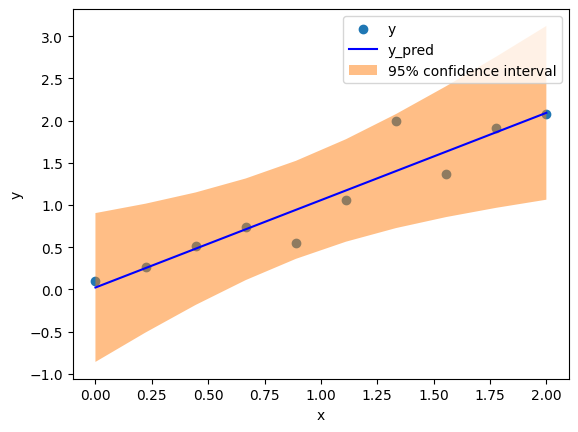

In [14]:
# Plotting the posterior predictive with 95% confidence interval
plt.scatter(X, y, label='y')
plt.plot(X, test_mean.detach().numpy(), 'b-', label='y_pred')

conf_int = 1.96 * np.sqrt(test_var.detach().numpy())
# Making conf_int into a column vector
conf_int = conf_int.reshape(-1, 1)

plt.fill_between(X.ravel(), (test_mean.detach().numpy() - conf_int).reshape(-1), (test_mean.detach().numpy() + conf_int).reshape(-1), alpha=0.5, label = '95% confidence interval')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

#### Splitting the dataset into retained and deleted data

In [15]:
# Creating two subsets of X and y
X1 = X[:4]
X2 = X[4:6]
X3 = X[6:7]
X4 = X[7:8]
X5 = X[8:]

y1 = y[:4]
y2 = y[4:6]
y3 = y[6:7]
y4 = y[7:8]
y5 = y[8:]

# Contatenating the subsets
X_retained = torch.cat((X1, X3, X5), 0)
X_deleted = torch.cat((X2, X4), 0)
y_retained = torch.cat((y1, y3, y5), 0)
y_deleted = torch.cat((y2, y4), 0)

#### Fitting a similar model on the retained data for reference

In [16]:
# Initializing the model
retained_model = torch.nn.Sequential(
    torch.nn.Linear(1, 1)
)

In [17]:
list(retained_model.parameters())

[Parameter containing:
 tensor([[0.9031]], requires_grad=True),
 Parameter containing:
 tensor([-0.8495], requires_grad=True)]

In [18]:
# Training the model
optimizer = torch.optim.Adam(retained_model.parameters(), lr=LR)
for i in range(EPOCHS):
    y_pred = retained_model(X_retained)
    loss = loss_fn(y_pred, y_retained)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

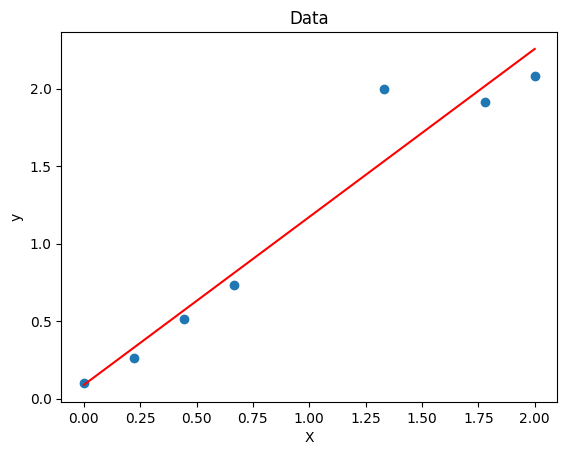

In [19]:
# Plotting the results
plt.scatter(X_retained, y_retained)
plt.plot(X, retained_model(X).detach().numpy(), 'r', label='Retained model')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Data')
plt.show()

In [20]:
# Output the mean loss of the retained model and the MLE parameters
y_pred = retained_model(X_deleted)
loss = loss_fn(y_pred, y_deleted)
print('Mean loss of the retained model:', loss.item())
print('MLE parameters:', list(retained_model.parameters()))

Mean loss of the retained model: 0.15815481543540955
MLE parameters: [Parameter containing:
tensor([[1.0832]], requires_grad=True), Parameter containing:
tensor([0.0891], requires_grad=True)]


In [21]:
# Creating the dataset to use in the Laplace approximation model
train_dataset = torch.utils.data.TensorDataset(X_retained, y_retained)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

In [22]:
# Re-training the model
retained_la_model = Laplace(retained_model, likelihood = 'regression', subset_of_weights='all', hessian_structure='full')
retained_la_model.fit(train_loader)
retained_la_model.optimize_prior_precision()

In [23]:
# Getting the predictive posterior
test_mean, test_var = retained_la_model(X)

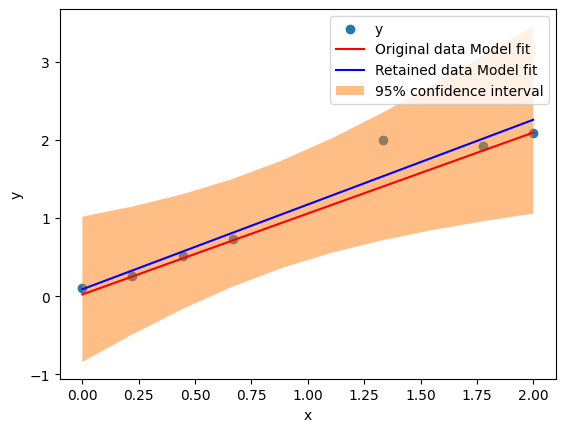

In [24]:
# Plotting the posterior predictive with 95% confidence interval
plt.scatter(X_retained, y_retained, label='y')
plt.plot(X, model(X).detach().numpy(), 'r', label='Original data Model fit')
plt.plot(X, test_mean.detach().numpy(), 'b-', label='Retained data Model fit')

conf_int = 1.96 * np.sqrt(test_var.detach().numpy())
# Making conf_int into a column vector
conf_int = conf_int.reshape(-1, 1)

plt.fill_between(X.ravel(), (test_mean.detach().numpy() - conf_int).reshape(-1), (test_mean.detach().numpy() + conf_int).reshape(-1), alpha=0.5, label = '95% confidence interval')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


#### Applying Bayesian Unlearning on the deleted dataset

In [25]:
# Getting the covariance matrix of the model and the mean of the posterior
mean_vals = la_model.mean
cov = torch.diag(la_model.posterior_covariance.diagonal())
mean_vals, cov

(tensor([1.0345, 0.0231]),
 tensor([[0.1490, 0.0000],
         [0.0000, 0.2022]]))

In [26]:
# Initializing the model
unlearned_model = torch.nn.Sequential(
    torch.nn.Linear(1, 1)
)

In [27]:
lambda_L = 3

In [28]:
# Defining the optimization function based on bayes rule
def log_likelihood(y_pred, y_true):
    log_prob = dist.Normal(y_pred, scale = 1).log_prob(y_true).mean()
    return log_prob

def log_posterior():
    log_prob = 0.0
    index = 0
    for params in unlearned_model.parameters():
        params = params.reshape(-1)
        mean_value = mean_vals[index]
        scale = torch.sqrt(cov[index][index])
        log_prob += dist.Normal(mean_value, scale=scale).log_prob(params)
        index += 1
    return log_prob / 2

def unlearning_obj(y_pred, y_true):
    return log_likelihood(y_pred, y_true) - lambda_L * log_posterior()
    

In [29]:
# Training the model
optimizer = torch.optim.Adam(unlearned_model.parameters(), lr=LR)
for i in range(EPOCHS):
    y_pred = unlearned_model(X_deleted)
    loss = unlearning_obj(y_pred, y_deleted)
    if(i % 100 == 0):
        print(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

2.0045313835144043


-0.8409228324890137
-0.8410048484802246
-0.8410047888755798
-0.8410047888755798
-0.8410047888755798
-0.8410047888755798
-0.8410047888755798
-0.8410047888755798
-0.8410047292709351
-0.8410047292709351
-0.8410047292709351
-0.8410047292709351
-0.8410047292709351
-0.8410047292709351
-0.8410047292709351
-0.8410047292709351
-0.8410048484802246
-0.8410048484802246
-0.8410048484802246
-0.8410048484802246
-0.8410048484802246
-0.8410048484802246
-0.8410048484802246
-0.8410048484802246


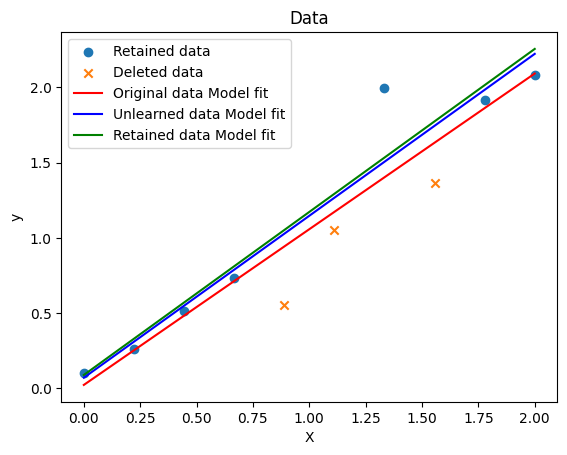

In [30]:
# Plotting the results
plt.scatter(X_retained, y_retained, label='Retained data')
plt.scatter(X_deleted, y_deleted, marker='x', label='Deleted data')
plt.plot(X, model(X).detach().numpy(), 'r', label='Original data Model fit')
plt.plot(X, unlearned_model(X).detach().numpy(), 'b-', label='Unlearned data Model fit')
plt.plot(X, retained_model(X).detach().numpy(), 'g-', label='Retained data Model fit')

plt.xlabel('X')
plt.ylabel('y')
plt.title('Data')
plt.legend()
# plt.savefig('plots/fit_l10')
plt.show()

In [31]:
# Output the mean loss of the unlearned model and the MLE parameters
y_pred = unlearned_model(X_retained)
loss = unlearning_obj(y_pred, y_retained)
print('Mean loss of the unlearned model:', loss.item())
print('MLE parameters:', list(unlearned_model.parameters()))

Mean loss of the unlearned model: -0.791253924369812
MLE parameters: [Parameter containing:
tensor([[1.0758]], requires_grad=True), Parameter containing:
tensor([0.0711], requires_grad=True)]


In [32]:
# Save the values of the unlearned model
unlearned_mean_vals = []

for params in unlearned_model.parameters():
    unlearned_mean_vals.append(params.detach().numpy().item())

unlearned_mean_vals

[1.0758267641067505, 0.07107860594987869]

#### Visualizing the contour plot of the unlearning objective

In [33]:
contour_model = torch.nn.Sequential(
    torch.nn.Linear(1, 1)
)

In [34]:
list(contour_model.parameters())

[Parameter containing:
 tensor([[0.4209]], requires_grad=True),
 Parameter containing:
 tensor([0.8928], requires_grad=True)]

In [35]:
def log_likelihood(y_pred, y_true):
    log_prob = dist.Normal(y_pred, scale = 1).log_prob(y_true).mean()
    return log_prob

def log_posterior():
    log_prob = 0.0
    index = 0
    for params in contour_model.parameters():
        params = params.reshape(-1)
        mean_value = mean_vals[index]
        scale = torch.sqrt(cov[index][index])
        log_prob += dist.Normal(mean_value, scale=scale).log_prob(params)
        index += 1
    return log_prob / 2

def unlearning_obj(y_pred, y_true):
    return log_likelihood(y_pred, y_true) - lambda_L * log_posterior()

C:\Users\nokze\AppData\Roaming\Python\Python310\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


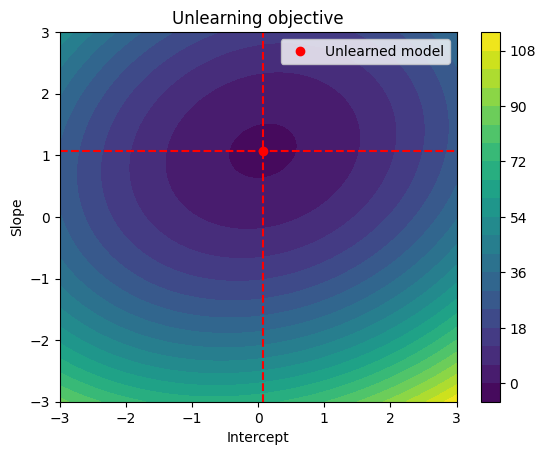

In [36]:
# Creating a contour plot of the unlearning objective
# Creating a meshgrid using torch
POINTS = 300
x = torch.linspace(-3, 3, POINTS)
y = torch.linspace(-3, 3, POINTS)
X, Y = torch.meshgrid(x, y)

# Finding the unlearning objective for each value in the meshgrid
Z = torch.zeros((POINTS, POINTS))
for i in range(POINTS):
    for j in range(POINTS):
        # params = torch.tensor([X[i][j], Y[i][j]])
        intercpet = X[i][j]
        slope = Y[i][j]
        contour_model[0].weight.data = torch.tensor([[slope]])
        contour_model[0].bias.data = torch.tensor([intercpet])
        y_pred = contour_model(X_deleted)
        Z[i][j] = unlearning_obj(y_pred, y_deleted)

# Plotting the contour plot
plt.contourf(X, Y, Z.detach().numpy(), 20)
plt.xlabel('Intercept')
plt.ylabel('Slope')
# Add a point to the plot from the unlearned_mean_vals
plt.plot(unlearned_mean_vals[1], unlearned_mean_vals[0], 'ro', label='Unlearned model')

# Add vertical and horizontal lines for the above points
plt.axvline(unlearned_mean_vals[1], color='r', linestyle='--')
plt.axhline(unlearned_mean_vals[0], color='r', linestyle='--')

plt.title('Unlearning objective')
plt.legend()
plt.colorbar()
# check if there is a directory names "plots", if not, create it
# if not os.path.exists('plots'):
#     os.makedirs('plots')
# plt.savefig('plots/contour_l10.png')
plt.show()

In [37]:
# Print the minimum value stored in Z
print('Minimum value of the unlearning objective: ', Z.min().item())

Minimum value of the unlearning objective:  -0.8409830331802368


#### Getting the Hessian for the Laplace approximation on the unlearned posterior

In [38]:
# Defining the funtional loss functions
def func_log_posterior(params):
    partial_params_leaves = jtu.tree_leaves(params)
    log_prob = 0.0
    for i, param in enumerate(partial_params_leaves):
        data = param.data.flatten()
        for d in data:
            log_prob += dist.Normal(mean_vals[i], torch.sqrt(cov[i][i])).log_prob(d)
    return log_prob / 2

def func_log_likelihood(params, model, X, y):
    y_pred = torch.func.functional_call(model, params, X).squeeze()
    log_prob = dist.Normal(y_pred, scale = 1).log_prob(y).mean()
    return log_prob

def func_neg_log_joint(params, model, X, y):
    # return func_neg_log_likelihood(params, model, X, y) + func_neg_log_prior(params, prior_var)
    return func_log_likelihood(params, model, X, y) - lambda_L * func_log_posterior(params)

In [39]:
# Defining the params_dict
params_dict = dict(unlearned_model.named_parameters())

In [40]:
params_dict

{'0.weight': Parameter containing:
 tensor([[1.0758]], requires_grad=True),
 '0.bias': Parameter containing:
 tensor([0.0711], requires_grad=True)}

In [41]:
partial_func_neg_log_joint = partial(func_neg_log_joint, model=unlearned_model, X = X_deleted, y = y_deleted)

In [42]:
H = torch.func.hessian(partial_func_neg_log_joint)(params_dict)
H

{'0.weight': {'0.weight': tensor([[[[-1.4815]]]], grad_fn=<ViewBackward0>),
  '0.bias': tensor([[[-1.1852]]], grad_fn=<ViewBackward0>)},
 '0.bias': {'0.weight': tensor([[[-1.1852]]], grad_fn=<ViewBackward0>),
  '0.bias': tensor([[-1.]], grad_fn=<ViewBackward0>)}}

In [43]:
def convert_hessian_dict_to_matrix(H, params_count):
    """
    Function to convert the hessian dictionary to a matrix

    Parameters
    ----------
    H : dict
        The hessian dictionary
    params_count : int
        The number of parameters in the model

    Returns
    -------
    H_matrix : torch.Tensor
        The hessian matrix
    """
    # Initializing the Hessian matrix
    H_matrix = torch.zeros((params_count, params_count))

    # Getting the dictionary of the named parameters
    named_parameters = dict(model.named_parameters())

    # List to store the size of the parameters in the dictionary
    size_params = []

    # Iterating over the named parameters and storing the size of the parameters
    for key in named_parameters:
        temp = []
        if len(named_parameters[key].shape) == 2:
            temp.append(named_parameters[key].shape[0])
            temp.append(named_parameters[key].shape[1])
        else:
            temp.append(named_parameters[key].shape[0])
        size_params.append(temp)

    # Iterating over the hessian dictionary and storing the values in the hessian matrix
    itr = 0
    H_mat_itr = 0
    for key1 in H:
        # If the value is a matrix
        if len(size_params[itr]) == 2:
            # Get the size of the matrix
            rows = size_params[itr][0]
            cols = size_params[itr][1]
            j = H_mat_itr
            y = 0
            # Iterating over the nested dictionary
            for key2 in H[key1]:
                # Get the number of parameters in the matrix
                no_params = H[key1][key2][0][0].flatten().shape[0]
                # Iterate over the rows and columns of the matrix
                for row in range(rows):
                    for col in range(cols):
                        flat_params = H[key1][key2][row][col].flatten()
                        H_matrix[j, y : y + no_params] = flat_params
                        j += 1
                y += no_params
                j = H_mat_itr
            H_mat_itr += rows * cols
        # If the value is not a matrix
        else:
            # Get the size of the 1D matrix
            rows = size_params[itr][0]
            j = H_mat_itr
            y = 0
            # Iterating over the nested dictionary
            for key2 in H[key1]:
                # Get the number of parameters in the 1D matrix
                no_params = H[key1][key2][0].flatten().shape[0]
                # Iterate over the rows of the 1D matrix
                for row in range(rows):
                    flat_params = H[key1][key2][row].flatten()
                    H_matrix[j, y : y + no_params] = flat_params
                    j += 1
                y += no_params
                j = H_mat_itr
            H_mat_itr += rows
        itr += 1

    return H_matrix

In [44]:
H_mat = convert_hessian_dict_to_matrix(H, 2)
H_mat

tensor([[-1.4815, -1.1852],
        [-1.1852, -1.0000]], grad_fn=<CopySlices>)

In [45]:
cov = torch.inverse(H_mat)
cov

tensor([[-13.0178,  15.4286],
        [ 15.4286, -19.2857]], grad_fn=<LinalgInvExBackward0>)

In [46]:
# Defining a function to check if a matrix is PSD
def isPSD(A):
    try:
        _ = la.cholesky(A)
        return True
    except la.LinAlgError:
        return False

In [47]:
isPSD(cov.detach().numpy())

False

In [88]:
# Converting the covariance matrix to PSD
cov =torch.inverse(H_mat + 10 * torch.eye(H_mat.shape[0]))

In [89]:
isPSD(cov.detach().numpy())

True

In [90]:
cov

tensor([[0.1196, 0.0157],
        [0.0157, 0.1132]], grad_fn=<LinalgInvExBackward0>)

#### Getting the predictive posterior of the unlearned model

In [50]:
# Getting the MAP estimate of the parameters
theta_MAP = hamiltorch.util.flatten(unlearned_model)

In [91]:
theta_MAP

tensor([1.0758, 0.0711], grad_fn=<CatBackward0>)

In [51]:
# Fitting a Laplace Approximation for the posterior using the MAP estimates and the covariance matrix
posterior = dist.MultivariateNormal(theta_MAP, cov)

In [52]:
sample_model = torch.nn.Sequential(
    torch.nn.Linear(1, 1)
)

In [53]:
# Defining function to generate mc samples from the posterior
def get_mc_samples(x, n_samples, posterior):
    """
    Function to get the monte carlo samples from the posterior and return the mean and standard deviation of the predictions

    Parameters
    ----------
    x : torch.Tensor
        The input tensor
    n_samples : int
        The number of samples to be drawn from the posterior
    posterior : torch.distributions.Distribution
        The posterior distribution

    Returns
    -------
    mean : float
        The mean of the predictions from the posterior
    std : float
        The standard deviation of the predictions from the posterior
    """
    samples = posterior.sample((n_samples,))
    pred = []
    for theta in samples:
        params_list = hamiltorch.util.unflatten(sample_model, theta)
        hamiltorch.util.update_model_params_in_place(sample_model, params_list)
        pred.append(sample_model(x).detach().numpy())
    
    return np.mean(pred), np.std(pred)


In [100]:
X = torch.linspace(-1, 3, N + 100).reshape(-1, 1)
y = X + 0.3 * torch.randn(N + 100, 1)

In [101]:
X.shape

torch.Size([110, 1])

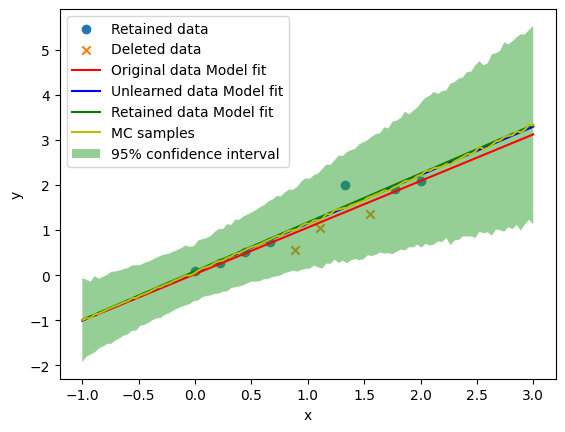

In [102]:
# Plotting the predictive posterior with 95% confidence interval
MC_SAMPLES = 1000

# Plot the predictive posterior using MC samples. Sample from the posterior distribution and plot the mean and standard deviation of the predictions
mean = []
std = []

for x in X:
    mean_pred, std_pred = get_mc_samples(x, MC_SAMPLES, posterior)
    mean.append(mean_pred)
    std.append(std_pred)

plt.scatter(X_retained, y_retained, label='Retained data')
plt.scatter(X_deleted, y_deleted, marker='x', label='Deleted data')
# plt.scatter(X, y, label='y')
plt.plot(X, model(X).detach().numpy(), 'r', label='Original data Model fit')
plt.plot(X, unlearned_model(X).detach().numpy(), 'b-', label='Unlearned data Model fit')
plt.plot(X, retained_model(X).detach().numpy(), 'g-', label='Retained data Model fit')
plt.plot(X, mean, 'y-', label='MC samples')
plt.fill_between(X.ravel(), (np.array(mean) - 1.96 * np.array(std)).reshape(-1), (np.array(mean) + 1.96 * np.array(std)).reshape(-1), alpha=0.5, label = '95% confidence interval')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [95]:
print(std)

[0.33651266, 0.35785484, 0.39484853, 0.42953902, 0.5055896, 0.54618305, 0.628612, 0.6576468, 0.7666246, 0.8212739]
